# Used libraries

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,GridSearchCV
from sklearn.feature_selection import SelectKBest,chi2,RFE,f_classif
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve,classification_report,auc
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import tree
import seaborn as sns
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier

# Load dataset 

In [3]:
traindf = pd.read_csv('./train.csv', index_col='ID_code')
testdf = pd.read_csv('./test.csv', index_col='ID_code')

In [30]:
traindf

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,train_199995,0,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
199996,train_199996,0,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
199997,train_199997,0,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,train_199998,0,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001


In [79]:
traindf.target.describe()

count    200000.000000
mean          0.100490
std           0.300653
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: target, dtype: float64

In [4]:
#Features Default selection
feature_name = traindf.columns.drop('target').tolist()
x = traindf.drop('target',axis=1)
y = traindf.target

## First step features selections : statistical's test
Features selection based on Pearson correlation , Chi2 and Anova Fvalue

In [73]:
#Preprocessing using Pearson Correlation
cor = traindf.corr()
#Correlation with output variable
cor_target = abs(cor["target"])
print(cor_target.describe())
#Number of highly correlated features with the target value
num_feats = cor_target[cor_target>0.04]
print("Number of highly correlated features with the target value ", len(num_feats))

count    201.000000
mean       0.032695
std        0.070933
min        0.000053
25%        0.013328
50%        0.026266
75%        0.040291
max        1.000000
Name: target, dtype: float64
Number of highly correlated features with the target value  53


In [129]:
num_feats = 50

In [114]:
def cor_selector(X, y,num_feats):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

def chi_selector(X, y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    return chi_support, chi_feature

def fvalue_selector(x, y,num_feats):
    fvalue_selector = SelectKBest(f_classif, k=num_feats)
    fvalue_selector.fit_transform(x, y)
    fvalue_support= fvalue_selector.get_support()
    fvalue_feature = x.loc[:,fvalue_support].columns.tolist()
    return fvalue_support, fvalue_feature

In [130]:
cor_support, cor_feature = cor_selector(x, y,num_feats)
chi_support, chi_feature = chi_selector(x, y,num_feats)
fvalue_support,fvalue_feature =  fvalue_selector(x, y,num_feats)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support,'Anova Fvalue' :fvalue_support })
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [137]:
feature_selection_df.head(50)

,Feature,Pearson,Chi-2,Anova Fvalue,Total
1,var_99,True,True,True,3
2,var_94,True,True,True,3
3,var_92,True,True,True,3
4,var_9,True,True,True,3
5,var_81,True,True,True,3
6,var_80,True,True,True,3
7,var_78,True,True,True,3
8,var_76,True,True,True,3
9,var_6,True,True,True,3
10,var_53,True,True,True,3


In [139]:
relevant_features = feature_selection_df[feature_selection_df.Total==3].Feature
print("Number of relevant features : ", len(relevant_features))
relevant_features

Number of relevant features :  45


1      var_99
2      var_94
3      var_92
4       var_9
5      var_81
6      var_80
7      var_78
8      var_76
9       var_6
10     var_53
11     var_44
12     var_40
13     var_34
14     var_33
15     var_26
16     var_22
17     var_21
18      var_2
19    var_198
20    var_191
21    var_190
22    var_184
23     var_18
24    var_179
25    var_174
26    var_170
27    var_169
28    var_166
29    var_165
30    var_164
31    var_154
32    var_148
33    var_146
34    var_139
35    var_133
36     var_13
37    var_123
38    var_122
39     var_12
40    var_115
41    var_110
42    var_109
43    var_108
44      var_1
45      var_0
Name: Feature, dtype: object

In [166]:
#Analysis of relevant features correlation between themselves
plt.figure(figsize=(15,15))
cor = traindf[relevant_features].corr()
columns = np.full((cor.shape[0],), True, dtype=bool)
for i in range(cor.shape[0]):
    for j in range(i+1, cor.shape[0]):
        if abs(cor.iloc[i,j]) >= 0.7:
            if columns[j]:
                columns[j] = False
relevant_features = traindf[relevant_features].columns[columns]
print("Number of relevant features : ", len(relevant_features))
relevant_features=relevant_features.tolist()
relevant_features

Number of relevant features :  45


['var_99',
 'var_94',
 'var_92',
 'var_9',
 'var_81',
 'var_80',
 'var_78',
 'var_76',
 'var_6',
 'var_53',
 'var_44',
 'var_40',
 'var_34',
 'var_33',
 'var_26',
 'var_22',
 'var_21',
 'var_2',
 'var_198',
 'var_191',
 'var_190',
 'var_184',
 'var_18',
 'var_179',
 'var_174',
 'var_170',
 'var_169',
 'var_166',
 'var_165',
 'var_164',
 'var_154',
 'var_148',
 'var_146',
 'var_139',
 'var_133',
 'var_13',
 'var_123',
 'var_122',
 'var_12',
 'var_115',
 'var_110',
 'var_109',
 'var_108',
 'var_1',
 'var_0']

<Figure size 1080x1080 with 0 Axes>

## Second step features selection : Wrapper Method
Recursive features elimination using the Gradient Boosting classifier, Logistic regression and desicion tree

In [167]:
def rfe_selector(X, y,num_feats,model):
    X_norm = MinMaxScaler().fit_transform(x)
    rfe_selector = RFE(estimator=model, n_features_to_select=num_feats, step=5, verbose=2)
    rfe_selector.fit(X_norm, y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = x.loc[:,rfe_support].columns.tolist()
    return rfe_support, rfe_feature

In [170]:
x = x[relevant_features]

In [173]:
log_support,log_feature = rfe_selector(x,y,num_feats =20 ,model=LogisticRegression)

Fitting estimator with 45 features.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 40 features.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 35 features.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 30 features.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 25 features.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [177]:
tree_support,tree_feature = rfe_selector(x,y,num_feats =20,model=tree.DecisionTreeClassifier)

Fitting estimator with 45 features.
Fitting estimator with 40 features.
Fitting estimator with 35 features.
Fitting estimator with 30 features.
Fitting estimator with 25 features.


In [178]:
xgb_support,xgb_feature = rfe_selector(x,y,num_feats =20,model=GradientBoostingClassifier) 

Fitting estimator with 45 features.
Fitting estimator with 40 features.
Fitting estimator with 35 features.
Fitting estimator with 30 features.
Fitting estimator with 25 features.


In [179]:
# put all selection together
rfe_selection_df = pd.DataFrame({'Feature':relevant_features, 'Gradient Boosting':xgb_support, 
                                 'Decision tree':tree_support,'Logistic regression' :log_support})
# count the selected times for each feature
rfe_selection_df['Total'] = np.sum(rfe_selection_df, axis=1)
# display the top 100
rfe_selection_df = rfe_selection_df.sort_values(['Total','Feature'] , ascending=False)
rfe_selection_df.index = range(1, len(rfe_selection_df)+1)

In [180]:
rfe_selection_df

,Feature,Gradient Boosting,Decision tree,Logistic regression,Total
1,var_99,True,True,True,3
2,var_81,True,True,True,3
3,var_76,True,True,True,3
4,var_6,True,True,True,3
5,var_53,True,True,True,3
6,var_26,True,True,True,3
7,var_21,True,True,True,3
8,var_174,True,True,True,3
9,var_166,True,True,True,3
10,var_165,True,True,True,3


In [181]:
relevant_features = rfe_selection_df[rfe_selection_df.Total==3].Feature
print("Number of relevant features : ", len(relevant_features))
relevant_features

Number of relevant features :  13


1      var_99
2      var_81
3      var_76
4       var_6
5      var_53
6      var_26
7      var_21
8     var_174
9     var_166
10    var_165
11    var_139
12     var_12
13    var_110
Name: Feature, dtype: object

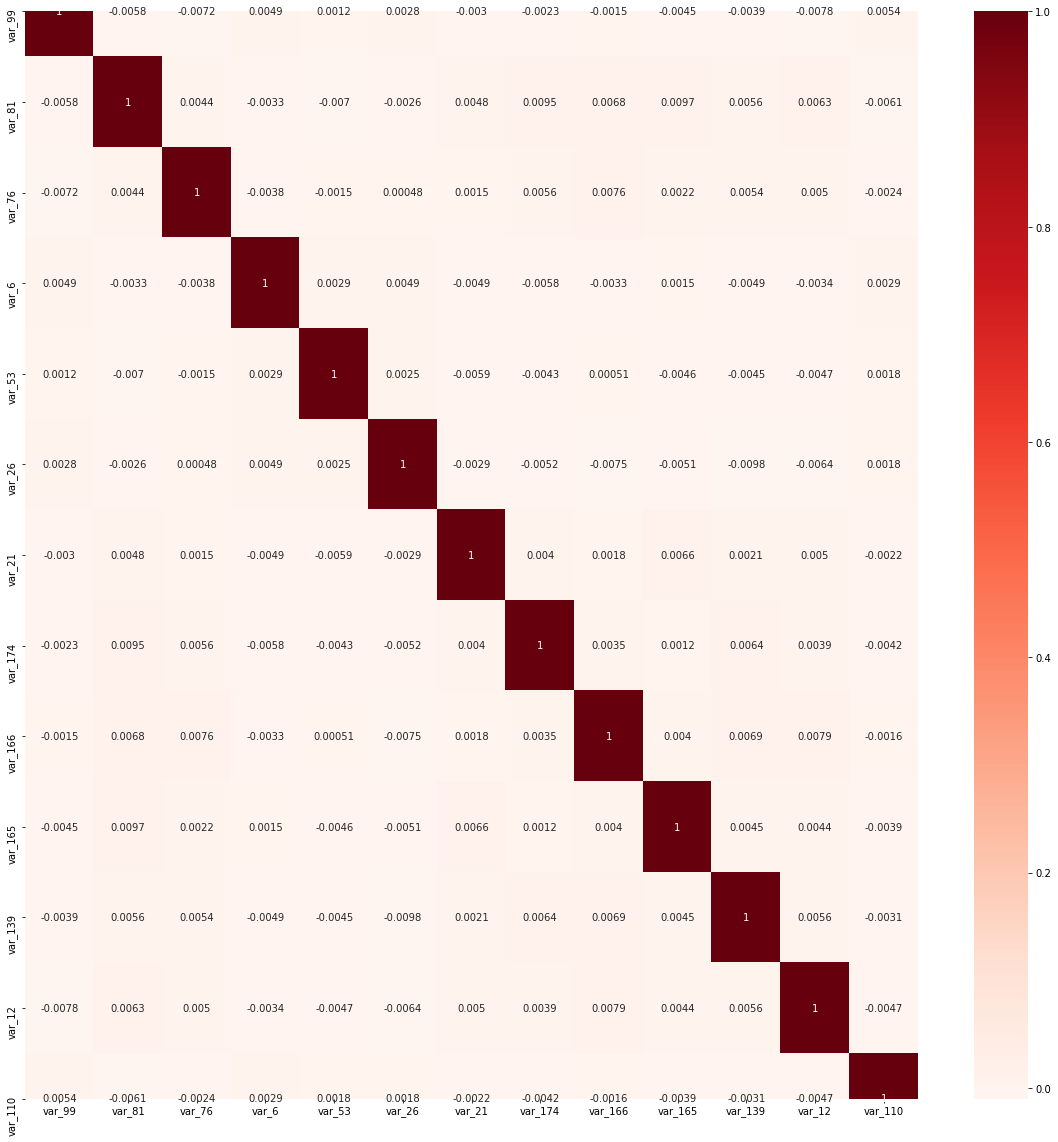

In [198]:
corr = traindf[relevant_features].corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()

# Modelisation part 


## Functions

In [50]:
def modelfit(model,X,Y,features,performCV=True,roc=False, printFeatureImportance=False):
    
    #Fitting the model on the data_set
    model.fit(X[features],Y)
        
    #Predict training set:
    predictions = model.predict(X[features])
    predprob = model.predict_proba(X[features])[:,1]
    
    # Create and print confusion matrix    
    cfm = confusion_matrix(Y,predictions)
    print("\nModel Confusion matrix")
    print(cfm)
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(Y.values, predictions))
    
    #Perform cross-validation: evaluate using 10-fold cross validation 
    kfold = StratifiedKFold(n_splits=10, shuffle=True)
  
    if performCV:
        evaluation(model,X[features],Y,kfold)
    if roc: 
        compute_roc(Y, predictions, plot=True)
          
    #Print Feature Importance:
    if printFeatureImportance:
        feature_importance(model,features,threshold = 0.02, selection=False) 

In [8]:
#Fonction d'evaluation 
def evaluation(model,X,Y,kfold):
    # Cross Validation to test and anticipate overfitting problem
    scores1 = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
    scores2 = cross_val_score(model, X, Y, cv=kfold, scoring='precision')
    scores3 = cross_val_score(model, X, Y, cv=kfold, scoring='recall')
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Accuracy: %0.5f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    print("Cross Validation Precision: %0.5f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    print("Cross Validation Recall: %0.5f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    return  

In [47]:
def compute_roc(Y, y_pred, plot=True):
    fpr = dict()
    tpr = dict()
    auc_score = dict()
    fpr, tpr, _ = roc_curve(Y, y_pred)
    auc_score = auc(fpr, tpr)
    if plot:
        plt.figure(figsize=(7, 6))
        plt.plot(fpr, tpr, color='blue',
                 label='ROC curve (area = %0.2f)' % auc_score)
        plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
        plt.legend(loc="upper right")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title("ROC Curve")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.show()
    return fpr, tpr, auc_score

In [10]:
def feature_importance(model,features,threshold,selection=False) : 
    feature_importances = pd.DataFrame(model.feature_importances_  )
    feature_importances = feature_importances.T
    feature_importances.columns = [features]
    
    sns.set(rc={'figure.figsize':(13,12)})
    fig = sns.barplot(data=feature_importances, orient='h', order=feature_importances.mean().sort_values(ascending=False).index)
    fig.set(title = 'Feature importance', xlabel = 'features', ylabel = 'features_importance' )
    
    if selection: #Selection of features with min threshold% of feature importance
        n_features = feature_importances[feature_importances.loc[:,] > threshold].dropna(axis='columns')
        n_features = n_features.columns.get_level_values(0)    
        print("Selected features")
        print(n_features)
        
    return fig

## Local train and test dataset

In [61]:
relevant_features = ['var_99','var_81','var_76','var_6','var_53',
                     'var_26','var_21','var_174','var_166','var_165','var_139','var_12','var_110']

In [59]:
#Train and test set splitting
x = traindf.drop('target',axis=1)
y = traindf.target
x_train, x_test, y_train, y_test = train_test_split(traindf[relevant_features], y , 
                                                    test_size=0.25, random_state =0)

## ML DecisionTreeClassifier

In [15]:
#Decison tree baseline model
model = tree.DecisionTreeClassifier()
#Fitting Decison tree baseline model
modelfit(model,x_train, y_train,relevant_features,performCV=False)
print("Accuracy on test set :{:.3f} ".format(model.score(x_test, y_test)))


Model Confusion matrix
[[135000      0]
 [     0  15000]]

Model Report
Accuracy : 1
Accuracy on test set :0.824 


In [17]:
#Tunning Decision tree model  With Gridsearch
print('Decision tree with Classifier')
params={'max_depth': np.arange(2, 8),'criterion':['gini','entropy']}
tree_estimator = tree.DecisionTreeClassifier()

kfold = 10 

grid_tree = GridSearchCV(tree_estimator, params, cv=kfold, scoring="accuracy",
                         n_jobs=1,
                         verbose=False)

grid_tree.fit(x_train, y_train)
best_est = grid_tree.best_estimator_
print(best_est)
print(grid_tree.best_score_)


# summarize results
print("Best: %f using %s" % (grid_tree.best_score_, grid_tree.best_params_))
means = grid_tree.cv_results_['mean_test_score']
stds = grid_tree.cv_results_['std_test_score']
params = grid_tree.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Decision tree with Classifier
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.9
Best: 0.900000 using {'criterion': 'gini', 'max_depth': 2}
0.900000 (0.000000) with: {'criterion': 'gini', 'max_depth': 2}
0.899813 (0.000358) with: {'criterion': 'gini', 'max_depth': 3}
0.899880 (0.000367) with: {'criterion': 'gini', 'max_depth': 4}
0.899753 (0.000512) with: {'criterion': 'gini', 'max_depth': 5}
0.899420 (0.000690) with: {'criterion': 'gini', 'max_depth': 6}
0.899173 (0.000693) with: {'criterion': 'gini', 'max_depth': 7}
0.900000 (0.000000) with: {'criterion': 'entropy', 'max_depth': 2}
0.899867 (0.000346) with: {'criterion': 'entropy', 'ma

**the best Hyperparameters for our Decision tree model using gridsearch Cv  is {'criterion': 'gini', 'max_depth': 4}**


Model Confusion matrix
[[134921     79]
 [ 14885    115]]

Model Report
Accuracy : 0.9002
Cross Validation Accuracy: 0.89993 (+/- 0.00)
Cross Validation Precision: 0.50858 (+/- 0.11)
Cross Validation Recall: 0.00620 (+/- 0.00)


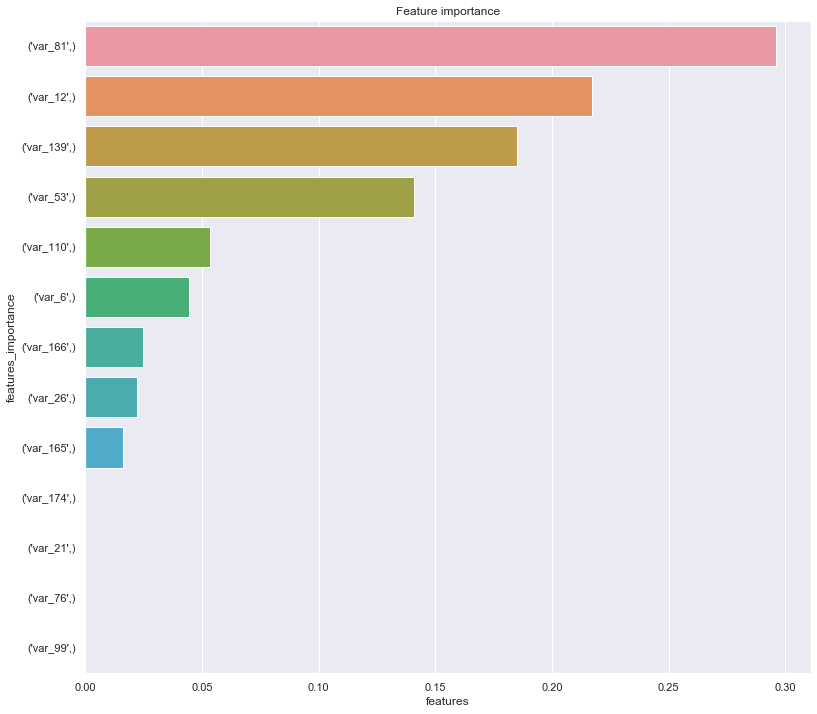

In [24]:
model = tree.DecisionTreeClassifier(max_depth = 4,criterion='gini')
modelfit(model,x_train, y_train,relevant_features,printFeatureImportance=True)

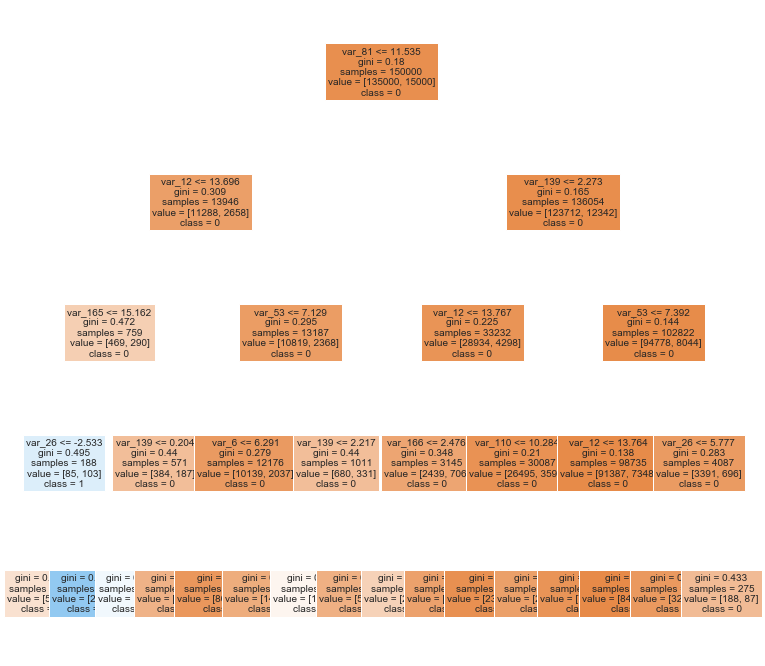

In [41]:
model = tree.DecisionTreeClassifier(max_depth = 4,criterion='gini') 
tree_features = ['var_81','var_6','var_53',
                'var_26','var_166','var_165','var_139','var_12','var_110']
cn=['0', '1']
clf = model.fit(x_train[tree_features], y_train)
plot_tree(clf, 
          feature_names =tree_features,
          class_names = cn,
          filled=True,fontsize=10)
plt.show()


Model Confusion matrix
[[134921     79]
 [ 14885    115]]

Model Report
Accuracy : 0.9002
Cross Validation Accuracy: 0.89983 (+/- 0.00)
Cross Validation Precision: 0.44783 (+/- 0.10)
Cross Validation Recall: 0.00747 (+/- 0.01)


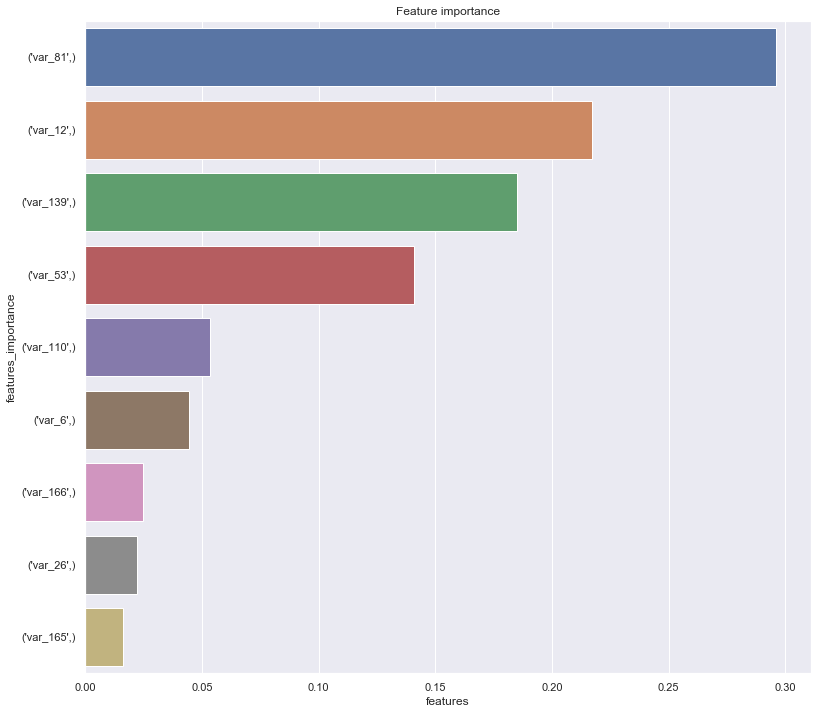

In [53]:
modelfit(model,x_train,y_train,tree_features, printFeatureImportance=True)

Fitting with test set

Model Confusion matrix
[[44869    33]
 [ 5033    65]]

Model Report
Accuracy : 0.8987
Cross Validation Accuracy: 0.89738 (+/- 0.00)
Cross Validation Precision: 0.39248 (+/- 0.13)
Cross Validation Recall: 0.00549 (+/- 0.00)


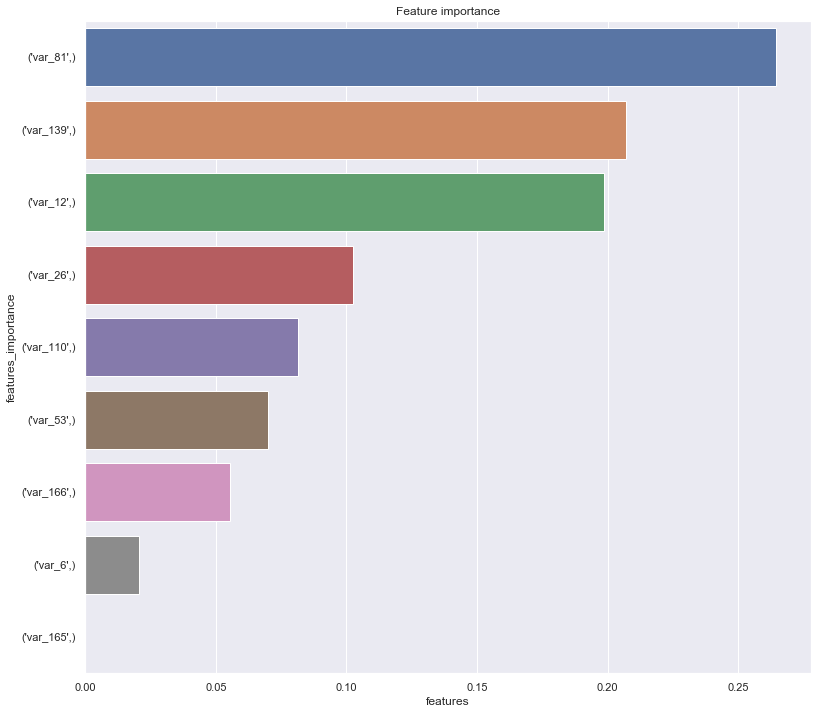

In [55]:
print("Fitting with test set")
modelfit(model,x_test, y_test,tree_features,printFeatureImportance=True)

## ML Gradient Boosting classifier

In [60]:
#Train and test set splitting
x = traindf.drop('target',axis=1)
y = traindf.target
x_train, x_test, y_train, y_test = train_test_split(traindf[relevant_features], y , 
                                                    test_size=0.25, random_state =0)


Model Confusion matrix
[[134722    278]
 [ 14324    676]]

Model Report
Accuracy : 0.9027
Cross Validation Accuracy: 0.90133 (+/- 0.00)
Cross Validation Precision: 0.60943 (+/- 0.05)
Cross Validation Recall: 0.03587 (+/- 0.01)


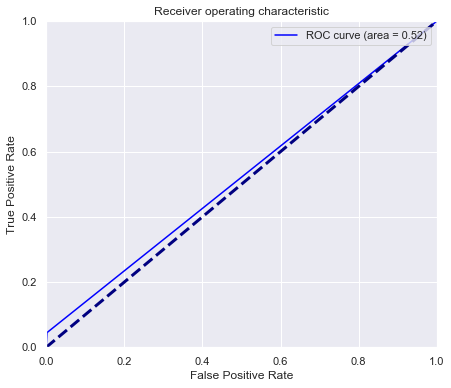

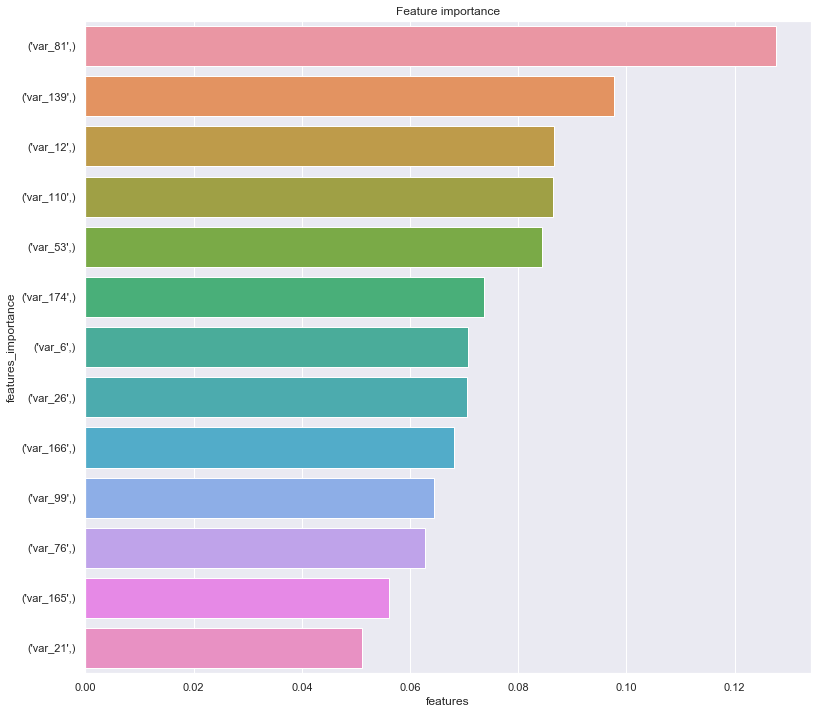

In [64]:
#Baseline Gradient boosting model 
base_gbm = GradientBoostingClassifier(random_state=10)
modelfit(base_gbm,x_train, y_train,relevant_features,roc=True,printFeatureImportance=True)

# **Tunning parameters with Gridsearch**
** Baseline approch**
   *Fix learning rate and number of estimators for tuning tree-based parameters
    min_samples_split = 500 : This should be ~0.5-1% of total values.
    min_samples_leaf = 50 :  for preventing overfitting and again a small value.
    max_depth = 8 : Should be choosen (5-8) based on the number of observations and predictors.
    max_features = ‘sqrt’ : Its a general thumb-rule to start with square root.
    subsample = 0.8 : commonly used used start value

**we will choose all the features 

In [65]:
print('tuning n_estimators')
params1 = {'n_estimators':range(30,81,10)}

estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                       min_samples_split=500,
                                       min_samples_leaf=50,
                                       max_depth=8,
                                       max_features='sqrt',
                                       subsample=0.8,
                                       random_state=10)

grid_xgb1 = GridSearchCV(estimator,
                  params1,
                  cv=5,
                  scoring='accuracy',
                  n_jobs=1,
                  verbose=False)

grid_result=grid_xgb1.fit(x_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

tuning n_estimators
Best: 0.900993 using {'n_estimators': 40}
0.900967 (0.000304) with: {'n_estimators': 30}
0.900993 (0.000367) with: {'n_estimators': 40}
0.900920 (0.000472) with: {'n_estimators': 50}
0.900860 (0.000562) with: {'n_estimators': 60}
0.900787 (0.000546) with: {'n_estimators': 70}
0.900647 (0.000585) with: {'n_estimators': 80}


In [66]:
print('tuning max_depth and min_sample_split')
params2 =  {'max_depth':range(5,16,2), 'min_samples_split':range(400,1001,200)}

estimator = GradientBoostingClassifier(learning_rate=0.1,
                                       n_estimators = 40,
                                       max_features='sqrt',
                                       subsample=0.8,
                                       random_state=10)

grid_xgb2 = GridSearchCV(estimator,
                  params2,
                  cv=5,
                  scoring='accuracy',
                  n_jobs=-1,
                  verbose=True)

grid_result=grid_xgb2.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

tuning max_depth and min_sample_split
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 15.1min finished


Best: 0.901153 using {'max_depth': 5, 'min_samples_split': 600}
0.900993 (0.000122) with: {'max_depth': 5, 'min_samples_split': 400}
0.901153 (0.000332) with: {'max_depth': 5, 'min_samples_split': 600}
0.900813 (0.000201) with: {'max_depth': 5, 'min_samples_split': 800}
0.901007 (0.000272) with: {'max_depth': 5, 'min_samples_split': 1000}
0.901013 (0.000231) with: {'max_depth': 7, 'min_samples_split': 400}
0.900793 (0.000412) with: {'max_depth': 7, 'min_samples_split': 600}
0.900927 (0.000254) with: {'max_depth': 7, 'min_samples_split': 800}
0.901120 (0.000348) with: {'max_depth': 7, 'min_samples_split': 1000}
0.901067 (0.000310) with: {'max_depth': 9, 'min_samples_split': 400}
0.900747 (0.000232) with: {'max_depth': 9, 'min_samples_split': 600}
0.900807 (0.000367) with: {'max_depth': 9, 'min_samples_split': 800}
0.900987 (0.000120) with: {'max_depth': 9, 'min_samples_split': 1000}
0.900760 (0.000775) with: {'max_depth': 11, 'min_samples_split': 400}
0.900667 (0.000319) with: {'max_dep

In [68]:
print('tuning num_sample_split and min_sample_split')
params3 =  {'min_samples_leaf':range(40,70,10), 'min_samples_split':range(400,1001,200)}
estimator = GradientBoostingClassifier(learning_rate=0.1,
                                       n_estimators = 40,
                                       max_depth=5,
                                       max_features='sqrt',
                                       subsample=0.8,
                                       random_state=10)
grid_xgb3 = GridSearchCV(estimator,
                  params3,
                  cv=5,
                  scoring='accuracy',
                  n_jobs=-1,
                  verbose=True)
grid_result=grid_xgb3.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

tuning num_sample_split and min_sample_split
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.8min finished


Best: 0.901253 using {'min_samples_leaf': 50, 'min_samples_split': 600}
0.901020 (0.000305) with: {'min_samples_leaf': 40, 'min_samples_split': 400}
0.901233 (0.000236) with: {'min_samples_leaf': 40, 'min_samples_split': 600}
0.900947 (0.000195) with: {'min_samples_leaf': 40, 'min_samples_split': 800}
0.900833 (0.000184) with: {'min_samples_leaf': 40, 'min_samples_split': 1000}
0.901107 (0.000390) with: {'min_samples_leaf': 50, 'min_samples_split': 400}
0.901253 (0.000382) with: {'min_samples_leaf': 50, 'min_samples_split': 600}
0.900800 (0.000300) with: {'min_samples_leaf': 50, 'min_samples_split': 800}
0.900940 (0.000250) with: {'min_samples_leaf': 50, 'min_samples_split': 1000}
0.901107 (0.000351) with: {'min_samples_leaf': 60, 'min_samples_split': 400}
0.901073 (0.000366) with: {'min_samples_leaf': 60, 'min_samples_split': 600}
0.900933 (0.000226) with: {'min_samples_leaf': 60, 'min_samples_split': 800}
0.900860 (0.000308) with: {'min_samples_leaf': 60, 'min_samples_split': 1000}


In [70]:
print('tuning max_features')
params4 =  {'max_features':range(2,len(relevant_features),1)}

estimator = GradientBoostingClassifier(learning_rate=0.1,
                                       n_estimators = 40,
                                       max_depth=5,                                        
                                       min_samples_split=600, 
                                       min_samples_leaf=50, 
                                       subsample=0.8,
                                       random_state=10)
grid_xgb4 = GridSearchCV(estimator,
                  params4,
                  cv=5,
                  scoring='accuracy',
                  n_jobs=1,
                  verbose=True)
grid_result=grid_xgb4.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds , params):
    print("%f (%f) with: %r" % (mean, stdev, param))

tuning max_features
Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:  8.1min finished


Best: 0.901253 using {'max_features': 3}
0.900987 (0.000243) with: {'max_features': 2}
0.901253 (0.000382) with: {'max_features': 3}
0.901153 (0.000291) with: {'max_features': 4}
0.901133 (0.000406) with: {'max_features': 5}
0.901013 (0.000415) with: {'max_features': 6}
0.901040 (0.000275) with: {'max_features': 7}
0.901247 (0.000278) with: {'max_features': 8}
0.901107 (0.000337) with: {'max_features': 9}
0.901107 (0.000292) with: {'max_features': 10}
0.901193 (0.000485) with: {'max_features': 11}
0.901173 (0.000465) with: {'max_features': 12}


In [72]:
grid_result.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=3, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=50, min_samples_split=600,
                           min_weight_fraction_leaf=0.0, n_estimators=40,
                           n_iter_no_change=None, presort='auto',
                           random_state=10, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [73]:
xgb_tunned = GradientBoostingClassifier(learning_rate=0.1,
                                        n_estimators = 80,
                                        max_depth=5,
                                        min_samples_split=400, 
                                        min_samples_leaf=50, 
                                        max_features = 3,
                                       subsample=0.8,
                                       random_state=1 )


Model Confusion matrix
[[134562    438]
 [ 14002    998]]

Model Report
Accuracy : 0.9037
Cross Validation Accuracy: 0.90144 (+/- 0.00)
Cross Validation Precision: 0.55678 (+/- 0.04)
Cross Validation Recall: 0.05353 (+/- 0.00)

Model Confusion matrix
[[44772   130]
 [ 4681   417]]

Model Report
Accuracy : 0.9038
Cross Validation Accuracy: 0.89946 (+/- 0.00)
Cross Validation Precision: 0.57696 (+/- 0.05)
Cross Validation Recall: 0.05531 (+/- 0.01)


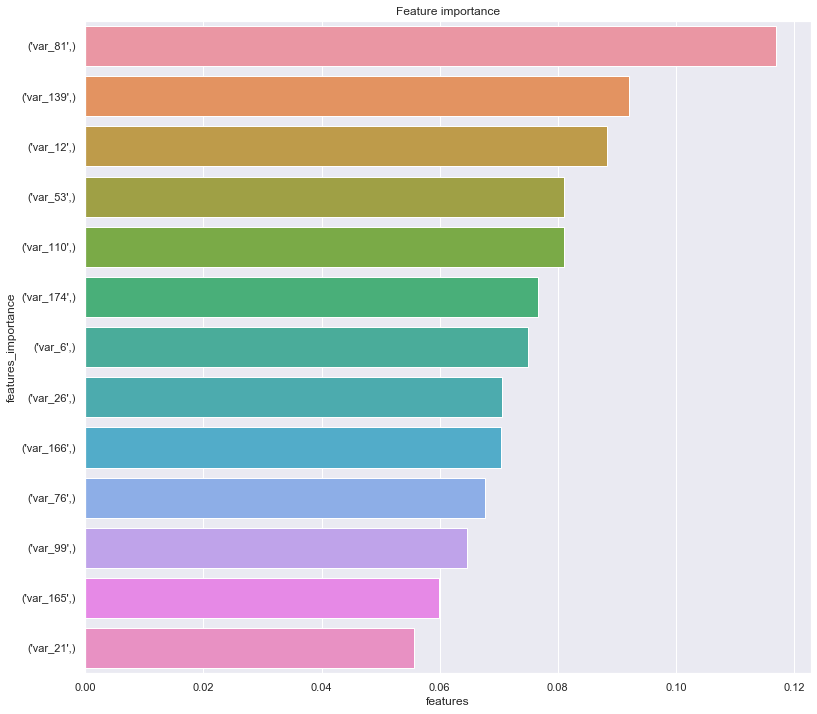

In [75]:
#Fit Cross validation and prediction on the train and the test set
modelfit(xgb_tunned,x_train, y_train,relevant_features,performCV=True,roc=False,printFeatureImportance=True)
modelfit(xgb_tunned,x_test,y_test,relevant_features,performCV=True,roc=False)


Model Confusion matrix
[[134562    438]
 [ 14002    998]]

Model Report
Accuracy : 0.9037


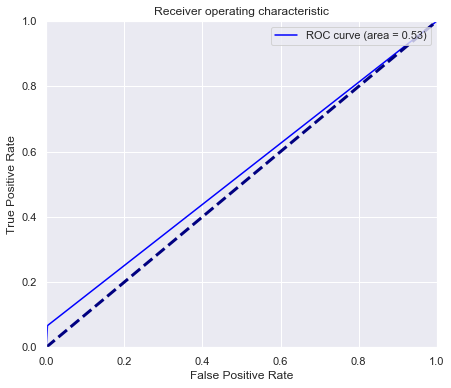


Model Confusion matrix
[[44772   130]
 [ 4681   417]]

Model Report
Accuracy : 0.9038


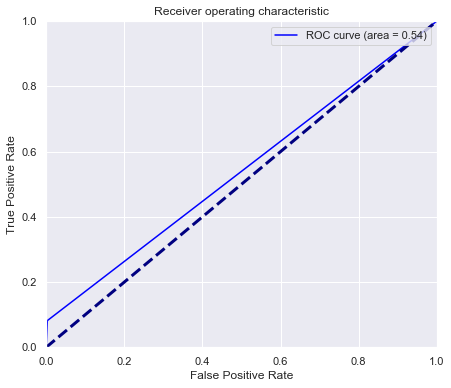

In [76]:
modelfit(xgb_tunned,x_train, y_train,relevant_features,performCV=False,roc=True,printFeatureImportance=False)
modelfit(xgb_tunned,x_test,y_test,relevant_features,performCV=False,roc=True,printFeatureImportance=False)